# 多层全连接神经网络

## 1 线性模型

### 1.1 一维线性回归

In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

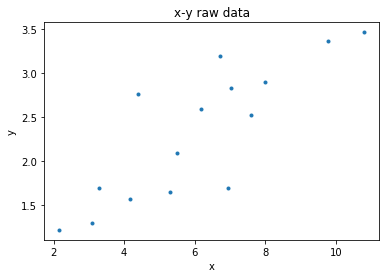

In [2]:
# 1.创建数据
x_train = np.array([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59,\
                    2.167, 7.042, 10.791, 5.313, 7.997, 3.1], dtype=np.float32)
y_train = np.array([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,\
                   2.827, 3.465, 1.65, 2.904, 1.3], dtype=np.float32)
x_train = np.reshape(x_train, [-1, 1])  # 转换为列向量
y_train = np.reshape(y_train, [-1, 1])
plt.plot(x_train, y_train, '.')
plt.title('x-y raw data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# 将numpy的数据转换为torch的tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train.shape

torch.Size([15, 1])

In [4]:
# 2.构建一维线性回归模型，即 y = w*x + b
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()              # python3中继承类的初始化方法
        self.linear = nn.Linear(1, 1)   # 定义一维的输入和输出
    def forward(self, x):               # 模型的前向传播
        output = self.linear(x)         # 计算output=w*x+b
        return output

In [5]:
# 3.实例化一个模型，并定义损失函数和优化函数
# if torch.cuda.is_available():
#     model = LinearRegression().cuda()   # 将模型放到GPU上执行
# else:
#     model = LinearRegression()
model = LinearRegression().cuda() if torch.cuda.is_available() else LinearRegression()
print('1.一维线性回归模型:\n',model)
criterion = nn.MSELoss()                             # 使用均分误差损失
optimizer = optim.SGD(model.parameters(), lr=1e-3)   # 使用SGD优化方法

1.一维线性回归模型:
 LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [6]:
# 4.开始训练模型
num_epochs = 300
# 先将训练数据变为Variable
inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
                if torch.cuda.is_available() \
                else (Variable(x_train), Variable(y_train))
for epoch in range(num_epochs):
    # forward
    out = model(inputs)                # 先进行前向传播
    loss = criterion(out, target)      # 计算损失函数
    # backward
    optimizer.zero_grad()              # 每次反向传播先归零梯度
    loss.backward()                    # 反向传播
    optimizer.step()                   # 更新参数
    # validate
    if (epoch + 1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss.data[0]))

Epoch[20/300], loss: 1.353648
Epoch[40/300], loss: 0.420303
Epoch[60/300], loss: 0.392920
Epoch[80/300], loss: 0.389962
Epoch[100/300], loss: 0.387685
Epoch[120/300], loss: 0.385448
Epoch[140/300], loss: 0.383235
Epoch[160/300], loss: 0.381044
Epoch[180/300], loss: 0.378876
Epoch[200/300], loss: 0.376730
Epoch[220/300], loss: 0.374606
Epoch[240/300], loss: 0.372503
Epoch[260/300], loss: 0.370422
Epoch[280/300], loss: 0.368363
Epoch[300/300], loss: 0.366324


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


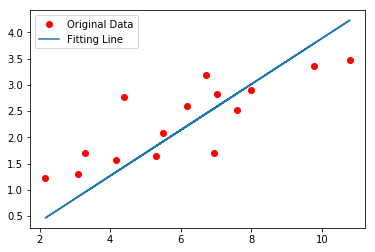

In [7]:
# 5.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
predict = model(inputs)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
# 是一条直线，所以顺序不会影响绘图
plt.plot(x_train.numpy(), predict, label='Fitting Line')  
plt.legend(['Original Data', 'Fitting Line'])
plt.show()

小结:
1. 创建数据或数据的读取及预处理
2. 构建网络模型
3. 实例化模型并定义损失函数及优化方法
4. 读入数据训练网络，同时输出准确率的验证结果
5. 测试模型的性能并可视化

### 1.2 多项式回归
每一维特征属性的次数不唯一

In [8]:
# 1.数据的创建和预处理
def make_features(x):
    """使数据X处理为多项式矩阵[x, x^2, x^3]"""
    x =x.unsqueeze(1)            # 参数1变为列向量，参数0变为行向量
    # 拼接的是tensor组成的列表，1表示按列拼接，0表示按行拼接 (0行1列)
    return torch.cat([x**i for i in range(1,4)], 1)   # 按列拼接为矩阵
# 使数据满足y=0.9+0.5*x+3*x^2+2.4*x^3关系，向量化为y = X*W + b
w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)   # 权重变为列向量
b_target = torch.Tensor([0.9])
def func(x):    # 构建函数关系式
    return x.mm(w_target) + b_target    # y = X*W + b，得到列向量

test = torch.Tensor([1,2,3,4,5,6,7])
test_out = make_features(test)
print('1.拼接后的矩阵:\n', test_out)
out = func(test_out)
print('2.满足多项式的输出:\n', out)

1.拼接后的矩阵:
 tensor([[   1.,    1.,    1.],
        [   2.,    4.,    8.],
        [   3.,    9.,   27.],
        [   4.,   16.,   64.],
        [   5.,   25.,  125.],
        [   6.,   36.,  216.],
        [   7.,   49.,  343.]])
2.满足多项式的输出:
 tensor([[   6.8000],
        [  33.1000],
        [  94.2000],
        [ 204.5000],
        [ 378.4000],
        [ 630.3000],
        [ 974.6000]])


In [9]:
# 上述函数合并为一个process_data
def process_data(input_x):           # 预处理数据
    input_x = input_x.unsqueeze(1)   # 得到列向量
    concat_x = torch.cat([input_x**i for i in range(1,4)], 1)  # 按列拼接为矩阵
    w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)        # 权重变为列向量
    b_target = torch.Tensor([0.9])
    output_y = concat_x.mm(w_target) + b_target                # 使数据符合多项式
    return concat_x, output_y
# test = torch.Tensor([1,2,3,4,5,6,7])
# x, y = process_data(test)
def get_batch(batch_size=32):      # 返回batch_size的(x,y)数据对用于训练
    random_data = torch.randn(batch_size)            # 随机产生高斯分布的数据
    x_train, y_train = process_data(random_data)     # 产生符合要求的数据
    inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
                if torch.cuda.is_available() \
                else (Variable(x_train), Variable(y_train))
    return inputs, target

In [10]:
# 2.构建模型并定义损失函数及优化方法
# 定义模型
class poly_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.poly = nn.Linear(3,1)   # y = X*W + b, x为3维，y为1维
    def forward(self, x):
        return self.poly(x)
model = poly_model().cuda() if torch.cuda.is_available() else poly_model()
# 定义损失函数与优化方法
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [11]:
# 3.训练模型
epoch = 0
while True:
    batch_x, batch_y = get_batch()       # 获取数据
    output = model(batch_x)              # 前向传播
    loss = criterion(output, batch_y)    # 计算损失函数
    print_loss = loss.data[0]
    optimizer.zero_grad()                # 梯度归零
    loss.backward()                      # 误差反向传播
    optimizer.step()                     # 更新参数
    epoch += 1        
    if print_loss < 1e-3:
        break
    if epoch % 100 == 0:
        print('Epoch[{}], loss: {:.6f}'.format(epoch+1, print_loss))

Epoch[101], loss: 8.549479
Epoch[201], loss: 1.421098
Epoch[301], loss: 1.129042
Epoch[401], loss: 0.114328
Epoch[501], loss: 0.096581
Epoch[601], loss: 0.015983
Epoch[701], loss: 0.009357
Epoch[801], loss: 0.005294
Epoch[901], loss: 0.003812
Epoch[1001], loss: 0.003300


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch[1101], loss: 0.002992
Epoch[1201], loss: 0.003096
Epoch[1301], loss: 0.002680
Epoch[1401], loss: 0.002587
Epoch[1501], loss: 0.003420
Epoch[1601], loss: 0.001991


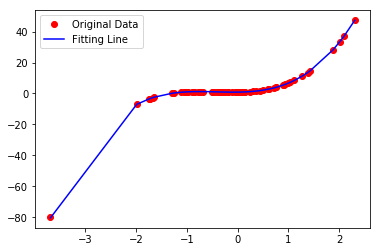

In [12]:
# 4.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
test_x, test_y = get_batch(64)
predict = model(test_x)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
test_x = test_x[:,0].unsqueeze(1)
plt.plot(test_x.numpy(), test_y.numpy(), 'ro', label='Original Data')
# 由于数据大小顺序是乱的，故无法画出曲线？？？
# plt.plot(test_x.numpy(), predict, 'b.',label='Fitting Data')
plt_data = np.concatenate((test_x.numpy(), predict), axis=1)
# 将数据按第一行排序后绘制直线
plt_data = plt_data[plt_data[:,0].argsort()]
plt.plot(plt_data[:,0], plt_data[:,1], 'b-', label='Fitting Line')
plt.legend()
plt.show()

## 2 分类问题

### 2.1 Logistic回归
Logistic回归中，输出y=1的对数概率是x的线性函数：

1. 拟合决策边界(线性或多项式都行)
2. 建立决策边界和分类概率的关系，得到分类概率

In [13]:
import torch
import numpy as np
from torch import nn, optim
%pylab inline
import matplotlib.pyplot as plt
from torch.autograd import Variable

Populating the interactive namespace from numpy and matplotlib


D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


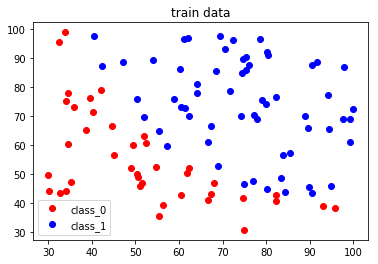

In [14]:
# 1.读取数据
def get_data(file_name):
    with open(file_name) as file:
        data_list = file.read().split('\n')     # 使用readlines会包含回车符
        # 使用map函数将子列表的每个元素转换为float
        data_list = [list(map(float, row.split(','))) for row in data_list]
        # 使用filter函数过滤数据，两类数据分开
        label0 = np.array(list(filter(lambda x: x[-1]==0, data_list)))
        label1 = np.array(list(filter(lambda x: x[-1]==1, data_list)))
    x0, y0 = label0[:, 0], label0[:, 1]
    x1, y1 = label1[:, 0], label1[:, 1]
    plt.plot(x0, y0, 'ro', label='class_0')
    plt.plot(x1, y1, 'bo', label='class_1')
    plt.legend(loc='best')
    plt.title('train data')
    plt.show()
    
    x_train = np.concatenate((label0[:,:2], label1[:, :2]), axis=0)  # 按行拼接
    y_train = np.array([0]*label0.shape[0] + [1]*label1.shape[0])    # 构建label
    data_train = np.concatenate((x_train, y_train[:,np.newaxis]), axis=1)
#     print(data_train)
    return data_train        # 返回 numpy格式的训练数据
mydata = get_data('data.txt')

In [15]:
# 产生训练模型的batch数据
import random
def get_batch(data, batch_size=100):                     # 生成数据的迭代器
    """data:特征+标签的numpy数据
       batch_size:批次的大小
       返回批次训练数据的生成器"""
    train_data = data
    order = list(range(len(train_data)))
    random.shuffle(order)               # shuffle作用于多维数组会出现重复的行！！！
    train_data = train_data[order]
    index = 0
#     print(type(data))
    while True:
        if index + batch_size < len(train_data):
            total_data = train_data[index: index+batch_size] # 按照行访问数据
            index += batch_size
        else:
            total_data = train_data[index:] 
            index = 0 
        yield total_data[:, :2], total_data[:, -1:]
g = get_batch(mydata)

In [16]:
test_x, test_y = next(g)
# print(test_x)
print(test_x.shape)
print(test_y.shape)

(100, 2)
(100, 1)


In [17]:
# 2.定义模型、损失函数及优化方法
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)   # 模型两个特征，一个输出
        self.sigm   = nn.Sigmoid()
    def forward(self, x):
        x = self.linear(x)
        out = self.sigm(x)
        return out
logistic_model = LogisticRegression().cuda() if torch.cuda.is_available() \
                 else LogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(logistic_model.parameters(), lr=1e-3, momentum=0.9)

**BCELoss()**

定义: $loss(o,t)=\frac{1}{n}\sum_i{(t_i \cdot log(o_i)+(1-t_i) \cdot log(1-o_i))}$

In [18]:
# 3.训练网络
num_epochs = 50000
gen = get_batch(mydata, batch_size=100)
for epoch in range(num_epochs):
    x, y = next(gen)
    x, y = map(torch.Tensor, (x,y))    # 将x，y转换为张量
    x_train, y_train = (Variable(x).cuda(), Variable(y).cuda()) \
                       if torch.cuda.is_available() \
                       else (Variable(x), Variable(y))  # 转换为Variable
    # 前向传播
    out = logistic_model(x_train)     # 计算输出
    loss = criterion(out, y_train)    # 计算损失函数
    print_loss = loss.data[0]         # 获取损失函数的值
    mask = out.ge(0.5).float()        # 大于0.5的设置为1，否则设置为0
    correct = (mask == y_train).sum()     # 统计预测正确的个数，这里得到整型tensor
#     print(correct.dtype)
    # 必须转换为numpy运算才行
    acc = correct.data[0].numpy() / y_train.shape[0]   # 计算准确率size(0)
#     print(acc)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 输出验证的结果
    if (epoch + 1) % 10000 == 0:
        print('-'*10)
        print('epoch {}'.format(epoch+1))
        print('loss is {:.4f}'.format(print_loss))
        print('acc is {:.4f}'.format(acc))

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


----------
epoch 10000
loss is 0.3906
acc is 0.9000
----------
epoch 20000
loss is 0.3178
acc is 0.9300
----------
epoch 30000
loss is 0.2844
acc is 0.9100
----------
epoch 40000
loss is 0.2650
acc is 0.9100
----------
epoch 50000
loss is 0.2525
acc is 0.9100


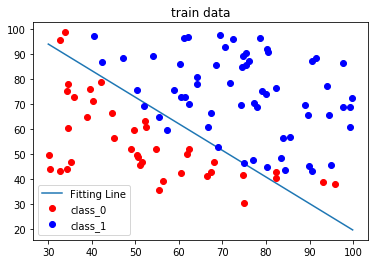

In [19]:
# 4.绘制拟合曲线
%matplotlib inline
# mydata = get_data('data.txt')
w0, w1 = logistic_model.linear.weight[0]      # 模型得到的变量均为Variable类型
w0, w1 = w0.data.numpy(), w1.data.numpy()
b = logistic_model.linear.bias.data.numpy()
plot_x = np.arange(30, 100, 0.1)
plot_y = (-w0 * plot_x - b) / w1
plt.plot(plot_x, plot_y, label='Fitting Line')
mydata = get_data('data.txt')                # pyplot画的图可以直接叠加

小结:
- random.shuffle()处理一维的列表和numpy数组时只是打乱顺序，但在处理多维numpy数组时，该函数会将数组的行随机的重复，所以要格外注意
- 在PyTorch中，在计算数值时最好转换到相同的格式，如都是numpy格式或tensor格式，防止出错
- 在PyTorch中，注意IntTensor()数据运算的'/'符号被认为整除符号，转换为float型计算除法
- matplotlib绘制的图可以直接叠加，即使一部分图是在函数中绘制的

In [20]:
# numpy数组排序
a = np.array([[1,3,2,0,5],[2, 4,3,1,6], [0, 2, 1, -1, 4]])
data = np.array(a)
print('1.原数据:\n', data)
print('2.按第3列排序:\n', data[data[:,2].argsort()] )  # 按第3列排序
print('3.按第2行排序:\n', data[:,data[1].argsort()])   # 按第2行排列

1.原数据:
 [[ 1  3  2  0  5]
 [ 2  4  3  1  6]
 [ 0  2  1 -1  4]]
2.按第3列排序:
 [[ 0  2  1 -1  4]
 [ 1  3  2  0  5]
 [ 2  4  3  1  6]]
3.按第2行排序:
 [[ 0  1  2  3  5]
 [ 1  2  3  4  6]
 [-1  0  1  2  4]]


In [21]:
# 该方法可以将程序写到py脚本中！！！
# %%writefile script_name.py
# def hello():
#     pass

## 3 多层全连接前向网络

In [22]:
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [23]:
# 设置超参数(Hyperparameters)
batch_size = 64
learning_rate = 1e-2
num_epochs = 20

In [24]:
# 1.读取数据及预处理
# Compose将各种预处理操作组合，ToTensor将图片处理为tensor，
# Normalize(mean, variance)正则化
data_tf = transforms.Compose([transforms.ToTensor(), \
                              transforms.Normalize([0.5], [0.5])])
# 下载MNIST手写数字训练集
train_dataset = datasets.MNIST(root='./data', train=True, transform=data_tf, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, transform=data_tf)
# 创建数据迭代器便于训练模型
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
print('1.训练数据的维度:')
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)
print('2.测试数据的维度:')
print(test_dataset.test_data.shape)
print(test_dataset.test_labels.shape)

1.训练数据的维度:
torch.Size([60000, 28, 28])
torch.Size([60000])
2.测试数据的维度:
torch.Size([10000, 28, 28])
torch.Size([10000])


1.0~9样本的索引: [10, 5, 35, 30, 6, 15, 21, 17, 84, 9]
2.手写体样本:


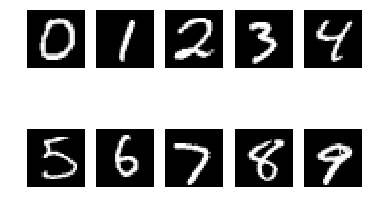

In [26]:
# 显示数据
%matplotlib inline
test = test_dataset.test_labels.numpy()     # 将tensor数据转换为numpy数据
sample_index = [np.where(test==i)[0][1] for i in range(10)]
print('1.0~9样本的索引:', sample_index)
sample_data = test_dataset.test_data[sample_index]    # 获取10个样本数据
print('2.手写体样本:')
for i in range(10):
    plt.subplot(2,5,i+1)
    sample_data = test_dataset.test_data[sample_index][i]
    plt.axis("off")       # 关掉坐标轴
    plt.imshow(sample_data, interpolation='none', cmap='gray')

In [27]:
# 2.定义模型
# (1)定义简单的模型
class Simple_Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__() 
        self.layer1 = nn.Linear(in_dim, n_hidden_1)      # 定义结构
        self.layer2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
    def forward(self, x):    # 前向传播
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
# (2)定义含激活函数的模型
class Activation_Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()    # 定义结构
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), \
                                    nn.ReLU(True))  
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), \
                                    nn.ReLU(True))
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
    def forward(self, x):    # 前向传播
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
# (3)定义含批标准化的模型
class Batch_Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()    # 定义结构
        # Sequential组合网络的层
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), \
                                    nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))  
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), \
                                    nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
    def forward(self, x):    # 前向传播
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [28]:
# 3.定义损失函数及优化方法
# model = Simple_Net(784, 300, 100, 10)    # Activation_Net, Batch_Net
# model = Activation_Net(784, 300, 100, 10) 
model = Batch_Net(784, 300, 100, 10) 
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.CrossEntropyLoss()       # 使用交叉熵损失函数
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# 4.训练模型
# 批次数据x:[64, 1, 28, 28], y:[64]
epoch = 0
for data in train_loader:
    x_train, y_train = data       # 获取训练批次数据
    # 前向传播
    # 注意：该处数据的维度应为[-1, input_dim]，第一个维度前面都是batch_size，
    # 但数据集尾部会出现不足batch_size的部分，-1更合理，第2个维度是固定的
    x_train = x_train.reshape([-1, 28*28]) # 使维度变为[-1, 28*28]
#     print(x_train.shape)
    out = model(x_train)                  # 计算模型输出 [64,10]
    loss = criterion(out, y_train)        # 计算损失函数
    print_loss = loss.data[0]
    # 反向传播
    optimizer.zero_grad()        # 梯度归零
    loss.backward()              # 梯度方向传播
    optimizer.step()             # 更新参数
    if (epoch + 1) % 100 == 0:
        print('Epoch {}'.format(epoch + 1))
        print('loss {:.4f}'.format(print_loss))
#         print('out {}'.format(out.shape))
    epoch += 1

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Epoch 100
loss 1.4164
Epoch 200
loss 0.9535
Epoch 300
loss 0.7836
Epoch 400
loss 0.7213
Epoch 500
loss 0.4279
Epoch 600
loss 0.4506
Epoch 700
loss 0.3839
Epoch 800
loss 0.3049
Epoch 900
loss 0.3275


In [30]:
# 5.评价模型的性能
model.eval()      # 将模型转换为测试状态
total_loss = 0
total_acc = 0
test_epoch = 0 
for data in test_loader:
    eval_loss = 0
    eval_acc = 0
    img, label = data      # 获取测试数据
#     print(img.shape)
    img = img.view(img.size(0), -1)    # 返回一个数据相同但维度不同的tensor
    # 由于测试状态下不需方向传播，所以可以释放缓存
    with torch.no_grad():
        img, label = (Variable(img).cuda(), Variable(label).cuda()) \
                     if torch.cuda.is_available() \
                     else (Variable(img), Variable(label))
    out = model(img)     # 计算图像的标签 [img.size(0), 10]
    loss = criterion(out, label)
    eval_loss += loss.data* label.size(0)   # 计算该批次的总损失
    _, pred = torch.max(out, 1)          # 在一行内按列比大小得[64,1],tenso为[64]
#     print(_, pred.shape)
    num_correct = (pred == label).sum()
    eval_acc += num_correct.data
#     print(eval_acc)    
    total_loss += eval_loss    # 累计所有批次数据的损失和准确率
    total_acc  += eval_acc
    if (test_epoch + 1) % 2 == 0:
        batch_loss  = (eval_loss / img.size(0))        # 计算该批次的损失
        batch_acc   = (eval_acc.float() / img.size(0)) # 计算该批次的准确率
        print('Epoch: {} Test Loss: {:.6f}, ACC: {:.6f}'.format(test_epoch+1, batch_loss, batch_acc))
    test_epoch += 1
print('----------Test Done!----------')
print('Epoch: {} Total_Loss: {:.6f} Total_ACC: {:.6f}'.format(\
      test_epoch, total_loss/len(test_dataset), total_acc.float()/len(test_dataset)))

Epoch: 2 Test Loss: 0.237892, ACC: 0.953125
Epoch: 4 Test Loss: 0.331582, ACC: 0.906250
Epoch: 6 Test Loss: 0.399676, ACC: 0.890625
Epoch: 8 Test Loss: 0.385936, ACC: 0.906250
Epoch: 10 Test Loss: 0.373855, ACC: 0.859375
Epoch: 12 Test Loss: 0.285056, ACC: 0.906250
Epoch: 14 Test Loss: 0.265675, ACC: 0.953125
Epoch: 16 Test Loss: 0.313558, ACC: 0.921875
Epoch: 18 Test Loss: 0.377609, ACC: 0.890625
Epoch: 20 Test Loss: 0.540064, ACC: 0.859375
Epoch: 22 Test Loss: 0.242032, ACC: 0.984375
Epoch: 24 Test Loss: 0.371329, ACC: 0.906250
Epoch: 26 Test Loss: 0.303058, ACC: 0.937500
Epoch: 28 Test Loss: 0.466064, ACC: 0.906250
Epoch: 30 Test Loss: 0.327193, ACC: 0.937500
Epoch: 32 Test Loss: 0.415637, ACC: 0.906250
Epoch: 34 Test Loss: 0.381162, ACC: 0.890625
Epoch: 36 Test Loss: 0.313300, ACC: 0.937500
Epoch: 38 Test Loss: 0.472537, ACC: 0.859375
Epoch: 40 Test Loss: 0.290053, ACC: 0.968750
Epoch: 42 Test Loss: 0.341906, ACC: 0.937500
Epoch: 44 Test Loss: 0.264664, ACC: 0.953125
Epoch: 46 Test

1.模型一

Epoch: 157 Total_Loss: 0.322252 Total_ACC: 0.906100


2.模型二

Epoch: 157 Total_Loss: 0.329867 Total_ACC: 0.906300

3.模型三

Epoch: 157 Total_Loss: 0.276453 Total_ACC: 0.940800